## This project aims to build a sentiment analysis from a dataset extracted from twitter. It uses BERT as tokenizer.

In [26]:
import numpy as np
import math
import re
import pandas as pd
from bs4 import BeautifulSoup
import random
import seaborn as sns
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow_hub as hub
from tensorflow.keras import layers
import bert

In [2]:
class DCNN(tf.keras.Model):
    def __init__(
        self,
        vocab_size,
        emb_dim=128,
        nb_filters = 50,
        FFN_units = 512,
        nb_classes = 2,
        dropout_rate = 0.1,
        training = False,
        name = "dcnn"
    ):
        super(DCNN,self).__init__(name=name)
        self.embedding = layers.Embedding(vocab_size, emb_dim)
        self.bigram = layers.Conv1D(
            filters = nb_filters,
            kernel_size = 2,
            padding = 'valid',
            activation = 'relu'
        )
        self.trigram = layers.Conv1D(
            filters = nb_filters,
            kernel_size = 3,
            padding = 'valid',
            activation = 'relu'
        )
        self.fourgram = layers.Conv1D(
            filters = nb_filters,
            kernel_size = 4,
            padding = 'valid',
            activation = 'relu'
        )
            
        self.pool = layers.GlobalMaxPool1D()
        self.dense_1 = layers.Dense(units = FFN_units, activation = 'relu')
        self.dropout = layers.Dropout(rate = dropout_rate)
        if nb_classes == 2:
            self.last_dense = layers.Dense(units = 1, activation = 'sigmoid')
        else:
            self.last_dense = layers.Dense(units= nb_classes, activation = 'softmax')
            
    def call(self, inputs, training):
        x = self.embedding(inputs)
        x_1 = self.bigram(x)
        x_1 = self.pool(x_1)
        x_2 = self.trigram(x)
        x_2 = self.pool(x_2)
        x_3 = self.fourgram(x)
        x_3 = self.pool(x_3)
        
        merged = tf.concat([x_1,x_2,x_3], axis = -1)
        merged = self.dense_1(merged)
        merged = self.dropout(merged, training)
        output = self.last_dense(merged)
        
        return output

In [16]:
class Sentiment:
    def __init__(self):
        self.cols = ['sentiment', 'id', 'date', 'query', 'user', 'text']
        self.data =  pd.read_csv('/home/nilton/Arquivos/Softplan/Tutorials/Curso_BERT_Jonathan/bert_data/Base de dados sentimentos/training.1600000.processed.noemoticon.csv',
                       header = None,
                       names = self.cols,
                       engine='python',
                       encoding='latin-1')
        self.data.drop(['id', 'date', 'query', 'user'],
             axis = 1, inplace = True)
        self.data_clean = [self.clean_tweet(tweet) for tweet in self.data.text]
        self.data_labels = self.data.sentiment.values
        self.data_labels[self.data_labels == 4] = 1
        self.FullTokenizer = bert.bert_tokenization.FullTokenizer
        self.bert_layer = hub.KerasLayer('https://tfhub.dev/tensorflow/bert_en_uncased_L-24_H-1024_A-16/1',
                               trainable = False)
        self.vocab_file = self.bert_layer.resolved_object.vocab_file.asset_path.numpy()
        self.do_lower_case = self.bert_layer.resolved_object.do_lower_case.numpy()
        self.tokenizer = self.FullTokenizer(self.vocab_file, self.do_lower_case)
        self.data_inputs = [self.encode_sentence(sentence) for sentence in self.data_clean]
        self.data_with_len = self.init_data_with_len()
        self.sorted_all = []
        self.min_token = 7
        self.data_handling()
    
    
    def clean_tweet(self,tweet):
        tweet = BeautifulSoup(tweet,'lxml').get_text()
        tweet = re.sub(r"@[A-Za-z0-9]+",' ',tweet)
        tweet = re.sub(r"https?://[A-Za-z0-9./]+",' ', tweet)
        tweet = re.sub(r"[^a-zA-Z.!?']", " ", tweet)
        tweet = re.sub(r" +", " ", tweet)
        return tweet
    
    def encode_sentence(self, sent):
        return self.tokenizer.convert_tokens_to_ids(self.tokenizer.tokenize(sent))
    
    def init_data_with_len(self):
        return [
            [
                sent, self.data_labels[i], len(sent)
            ]
            for i, sent in enumerate(self.data_inputs)
        ]
    
    def data_handling(self):
        random.shuffle(self.data_with_len)
        self.data_with_len.sort(key=lambda x: x[2])
        self.sorted_all = [
            (sent_lab[0], sent_lab[1])
            for sent_lab in self.data_with_len if sent_lab[2] > self.min_token
        ]
        self.BATCH_SIZE = 32
        self.NB_BATCHES = len(self.sorted_all) // self.BATCH_SIZE
        self.NB_BATCHES_TEST = self.NB_BATCHES // 10
        
        self.all_dataset = tf.data.Dataset.from_generator(lambda: self.sorted_all, 
                                            output_types = (tf.int32, tf.int32))
        self.all_batched = self.all_dataset.padded_batch(self.BATCH_SIZE, padded_shapes=((None,),()))
        self.all_batched.shuffle(self.NB_BATCHES)
        self.test_dataset = self.all_batched.take(self.NB_BATCHES_TEST)
        self.train_dataset = self.all_batched.skip(self.NB_BATCHES_TEST)
        
    def trainer(self):
        VOCAB_SIZE = len(self.tokenizer.vocab)
        EMB_DIM = 200
        NB_FILTERS = 100
        FFN_UNITS = 256
        NB_CLASSES = 2
        DROPOUT_RATE = 0.2
        NB_EPOCHS = 3
        #
        self.Dcnn = DCNN(
            vocab_size = VOCAB_SIZE,
            emb_dim = EMB_DIM,
            nb_filters = NB_FILTERS,
            FFN_units = FFN_UNITS,
            nb_classes = NB_CLASSES,
            dropout_rate = DROPOUT_RATE
        )
        if  NB_CLASSES == 2:
            self.Dcnn.compile(loss='binary_crossentropy', optimizer = 'adam', metrics = ['accuracy'])
        else:
            self.Dcnn.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics = ['sparse_categorical_accuracy'])
        
        checkpoint_path = './'
        ckpt = tf.train.Checkpoint(Dcnn= self.Dcnn)
        ckpt_manager = tf.train.CheckpointManager(ckpt, checkpoint_path,
                                         max_to_keep=1)
        if ckpt_manager.latest_checkpoint:
            ckpt.restore(ckpt_manager.latest_checkpoint)
            print('Lastest checkpoint restored')
        
        class MyCustomCallBack(tf.keras.callbacks.Callback):
            def on_epoch_end(self, epoch, logs = None):
                ckpt_manager.save()
                print(f"Checkpoint save at {checkpoint_path}")
        
        
        history = self.Dcnn.fit(
            self.train_dataset,
            epochs = NB_EPOCHS,
            callbacks = [MyCustomCallBack()]
        )
        results = self.Dcnn.evaluate(self.test_dataset)
        print(results)
        plt.plot(history.history['loss'])
        plt.title('Loss progress');
        plt.plot(history.history['accuracy'])
        plt.title('Accuracy progress');
        
    def  get_prediction(self,sentence):
        tokens = self.encode_sentence(sentence)
        inputs = tf.expand_dims(tokens, 0)
        output = self.Dcnn(inputs, training =False)
        sentiment = math.floor(output*2)
        if sentiment == 0:
            print("Negative")
        elif sentiment == 1:
            print("Positive")
        else:
            print("Undetermined")

In [17]:
OBJ = Sentiment()

Lastest checkpoint restored
Epoch 1/3
  37195/Unknown - 1415s 38ms/step - loss: 0.3454 - accuracy: 0.8495Checkpoint save at ./
37196/37196 [==============================] - 1415s 38ms/step - loss: 0.3454 - accuracy: 0.8495
Epoch 2/3
37196/37196 [==============================] - 1443s 39ms/step - loss: 0.3045 - accuracy: 0.8696
Epoch 3/3
4132/4132 [==============================] - 19s 4ms/step - loss: 0.4220 - accuracy: 0.8323
[0.4219573736190796, 0.8322846293449402]


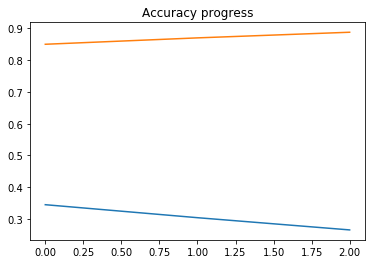

In [18]:
OBJ.trainer()

In [ ]:
## In blue, loss.

In [20]:
OBJ.get_prediction('I am so disappointed with you')

Negative


In [23]:
OBJ.get_prediction("I am sorry for your lost")

Negative


In [22]:
OBJ.get_prediction('I am glad that the economy in this country is evolving fastly')

Positive


In [24]:
OBJ.get_prediction("I'm here to conquer NLP!!!")

Positive


In [25]:
OBJ.get_prediction("He is an idiot!")

Negative


In [29]:
#### Saving the model

In [32]:
OBJ.Dcnn.save('Sentiment/sentiment')

INFO:tensorflow:Assets written to: Sentiment/sentiment/assets


INFO:tensorflow:Assets written to: Sentiment/sentiment/assets


In [ ]:
## Loading and testing the model

In [33]:
new_model = tf.keras.models.load_model('Sentiment/sentiment')

In [34]:
new_model.summary

<bound method Model.summary of <keras.saving.saved_model.load.DCNN object at 0x7f93cca05410>>

In [35]:
from copy import copy

In [36]:
OBJ2 = copy(OBJ)

In [37]:
OBJ2.Dcnn = new_model

In [38]:
OBJ2.get_prediction("I'm here to conquer NLP!!!")

Positive
